In [5]:
import numpy as np, scipy as sp
import pandas as pd
import pathlib
import torch
import math, json, re

In [7]:
metadata_df = pd.read_csv("circor_data/training_data.csv")
metadata_df.head(5)

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN


In [8]:
metadata_df.describe()

,Patient ID,Height,Weight,Additional ID
count,942.000000,826.000000,837.000000,140.000000
mean,66624.319533,110.800242,23.632756,58208.735714
std,16966.858912,30.000607,15.453337,10216.094378
min,2530.000000,35.000000,2.300000,23625.000000
25%,50263.250000,89.000000,12.500000,50092.000000
50%,68452.500000,115.000000,20.400000,50661.500000
75%,84938.500000,133.000000,31.200000,68466.250000
max,85349.000000,180.000000,110.800000,85234.000000


In [19]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Patient ID                942 non-null    int64  
 1   Recording locations:      942 non-null    object 
 2   Age                       868 non-null    object 
 3   Sex                       942 non-null    object 
 4   Height                    826 non-null    float64
 5   Weight                    837 non-null    float64
 6   Pregnancy status          942 non-null    bool   
 7   Murmur                    942 non-null    object 
 8   Murmur locations          179 non-null    object 
 9   Most audible location     179 non-null    object 
 10  Systolic murmur timing    178 non-null    object 
 11  Systolic murmur shape     178 non-null    object 
 12  Systolic murmur grading   178 non-null    object 
 13  Systolic murmur pitch     178 non-null    object 
 14  Systolic m

In [20]:
for col in metadata_df.columns:
    if col not in ["Patient ID", "Additional ID", "Height", "Weight"]:
        print(metadata_df[col].value_counts())

Recording locations:
AV+PV+TV+MV          586
AV+MV                115
PV+TV+MV              71
MV                    37
AV+PV+TV              29
AV+PV                 18
PV+TV                 14
AV+PV+MV              13
PV                    12
AV                     9
PV+MV                  7
AV+TV+MV               6
TV                     4
AV+PV+TV+TV+MV         4
AV+PV+TV+MV+MV         3
TV+MV                  2
AV+AV+PV+TV+MV         1
AV+AV+PV+TV+MV+MV      1
AV+AV+AV+MV            1
AV+PV+TV+MV+Phc        1
AV+MV+MV               1
AV+AV+MV+MV            1
AV+AV+MV               1
AV+PV+MV+Phc+Phc       1
AV+PV+PV+TV+TV+MV      1
PV+TV+TV               1
AV+AV+PV+PV+TV+MV      1
TV+MV+Phc              1
Name: count, dtype: int64
Age
Child         664
Infant        126
Adolescent     72
Neonate         6
Name: count, dtype: int64
Sex
Female    486
Male      456
Name: count, dtype: int64
Pregnancy status
False    872
True      70
Name: count, dtype: int64
Murmur
Absent     695
Pr

In [17]:
metadata_df[["Height", "Weight"]].describe()

,Height,Weight
count,826.000000,837.000000
mean,110.800242,23.632756
std,30.000607,15.453337
min,35.000000,2.300000
25%,89.000000,12.500000
50%,115.000000,20.400000
75%,133.000000,31.200000
max,180.000000,110.800000


In [35]:
data_dir = pathlib.Path("circor_data") / "training_data"
audio_headers = data_dir.glob("*.hea")
audio_lens = []
patient_ids = []
for audio_header in audio_headers:
    with open(audio_header, "r") as f:
        row1 = f.readlines()[0].strip().split(" ")
        # row is structured as ... [f_sampling] [n_samples]
        audio_len = int(row1[-1]) / (1.0 * int(row1[-2]))
        patient_ids.append(row1[0]) # doesnt handle spaces in patient id
        audio_lens.append(audio_len)
audio_lens = np.array(audio_lens)

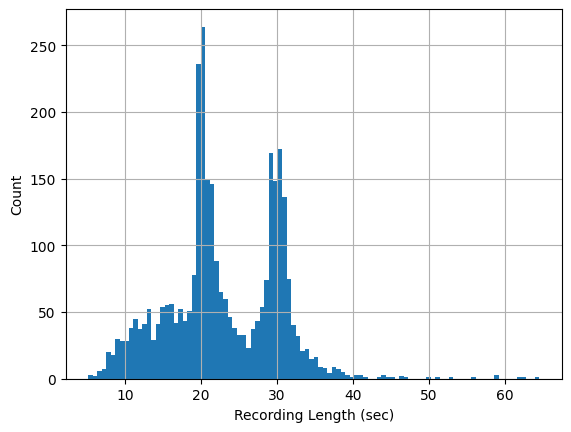

In [36]:
from matplotlib import pyplot as plt
plt.hist(audio_lens, bins=100)
plt.xlabel("Recording Length (sec)")
plt.ylabel("Count")
plt.grid()

In [49]:
print(audio_lens.shape, type(audio_lens))
is_long_enough = audio_lens > 15
shorts_i = (~is_long_enough).nonzero()
longs_i = is_long_enough.nonzero()

(3163,) <class 'numpy.ndarray'>


In [ ]:
# compare the labels for shorts and longs


In [54]:
with open("circor_data/RECORDS", "r") as f:
    records = f.readlines()
records = [pathlib.Path("circor_dir") / r.strip() for r in records]
print(type(records), len(records), records)

<class 'list'> 3163 [PosixPath('circor_dir/training_data/2530_AV'), PosixPath('circor_dir/training_data/2530_MV'), PosixPath('circor_dir/training_data/2530_PV'), PosixPath('circor_dir/training_data/2530_TV'), PosixPath('circor_dir/training_data/9979_AV'), PosixPath('circor_dir/training_data/9979_MV'), PosixPath('circor_dir/training_data/9979_PV'), PosixPath('circor_dir/training_data/9979_TV'), PosixPath('circor_dir/training_data/9983_AV'), PosixPath('circor_dir/training_data/9983_MV'), PosixPath('circor_dir/training_data/9983_PV'), PosixPath('circor_dir/training_data/9983_TV'), PosixPath('circor_dir/training_data/13918_AV'), PosixPath('circor_dir/training_data/13918_MV'), PosixPath('circor_dir/training_data/13918_PV'), PosixPath('circor_dir/training_data/13918_TV'), PosixPath('circor_dir/training_data/14241_AV'), PosixPath('circor_dir/training_data/14241_MV'), PosixPath('circor_dir/training_data/14241_PV'), PosixPath('circor_dir/training_data/14241_TV'), PosixPath('circor_dir/training_

In [133]:
# load an audio file 
import scipy as sp
import numpy as np

data_dir = pathlib.Path("circor_data") / "training_data"

murmur_file = data_dir / "85306_AV.wav"
fs, murmur_x = sp.io.wavfile.read(murmur_file)

if murmur_x.dtype == np.int16:
    print("16 bit")
    normalizer = 1.0 * 2 ** (16 - 1)
elif murmur_x.dtype == np.int32:
    print("32 bit")
    normalizer = 1.0 *  2 ** (32-1)

murmur_x = murmur_x[:int(fs * 15)] / normalizer
murmur_t = np.linspace(0, len(murmur_x)/(1.0 * fs), len(murmur_x))
assert (1/fs - (murmur_t[1] - murmur_t[0]) < 1e-8)

no_murmur_file = data_dir / "85338_TV.wav"
fs, normal_x = sp.io.wavfile.read(no_murmur_file)
normal_x = normal_x[:int(fs * 15)]  / normalizer
normal_t = np.linspace(0, len(normal_x)/(1.0 * fs), len(normal_x)) 
assert (1/fs - (normal_x[1] - normal_x[0]) < 1e-8)


16 bit


In [134]:
print(type(murmur_x), len(murmur_x))
print(type(normal_x), len(normal_x))

<class 'numpy.ndarray'> 60000
<class 'numpy.ndarray'> 60000


Text(0.5, 1.0, 'Raw Recording')

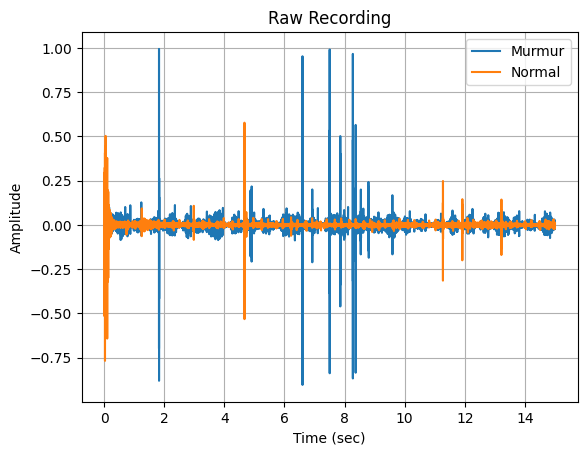

In [135]:
plt.plot(murmur_t, murmur_x, label="Murmur")
plt.plot(normal_t, normal_x, label="Normal")
plt.grid()
plt.legend()
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.title("Raw Recording")

Text(0.5, 1.0, 'Bandpass filtered')

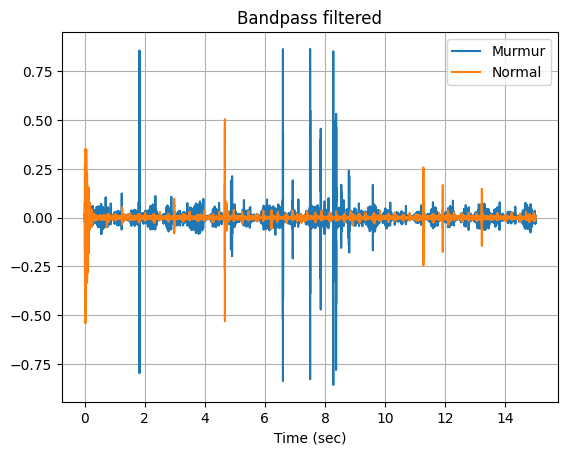

In [136]:
sos = sp.signal.butter(4, [20, 1000], btype="bandpass", output = "sos", fs=fs)
murmur_filt = sp.signal.sosfiltfilt(sos, murmur_x)
normal_filt = sp.signal.sosfiltfilt(sos, normal_x)
plt.plot(murmur_t, murmur_filt, label="Murmur")
plt.plot(normal_t, normal_filt, label="Normal")
plt.grid()
plt.legend()
plt.xlabel("Time (sec)")
plt.title("Bandpass filtered")

In [125]:
def spectrogram(x_t: np.ndarray):
    """
    """
    win = 0.5
    hop = 0.8 * win # 20% overlap either side
    n_per_seg = int(fs * win)
    n_overlap = n_per_seg - int(fs * hop)
    f, t, Sxx = sp.signal.spectrogram(x_t, fs, nperseg=n_per_seg, noverlap=n_overlap, window="tukey")

    # normalize across all frequencies and throw away outliers
    Sxx[Sxx > np.quantile(Sxx, 0.99)] = np.quantile(Sxx, 0.99)
    for i in range(Sxx.shape[1]):
        Sxx[:,i] = (Sxx[:,i]-np.mean(Sxx[:,i]))/np.std(Sxx[:,i])

    plt.pcolormesh(t, f, Sxx, cmap="jet")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0,2000)
    plt.xlim(0,15)
    plt.colorbar()

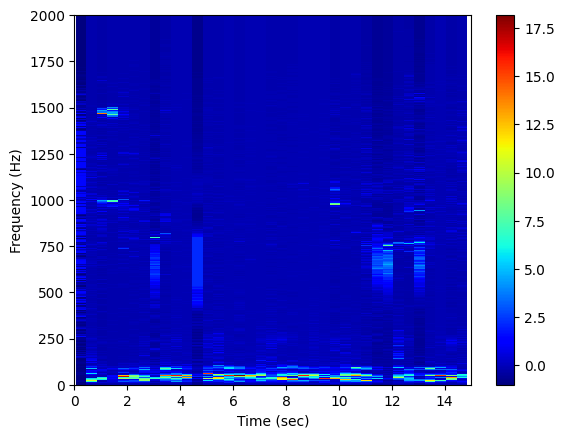

In [126]:
spectrogram(normal_x)

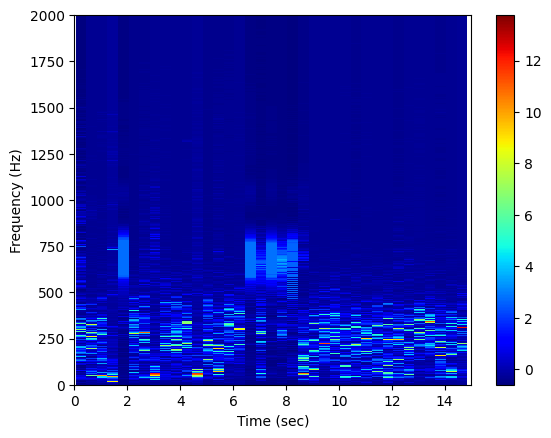

In [127]:
spectrogram(murmur_x)

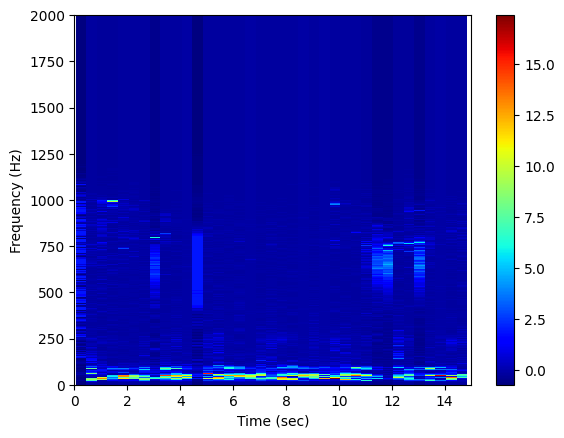

In [128]:
spectrogram(normal_filt)

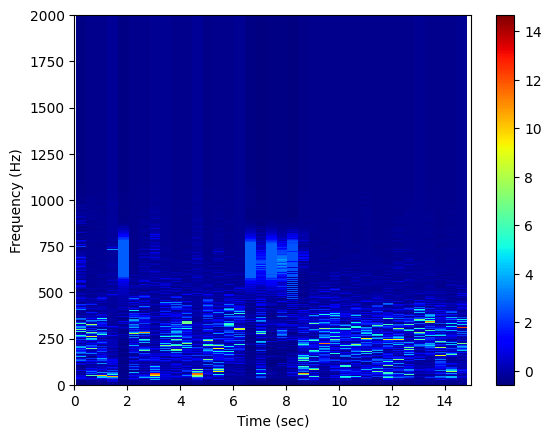

In [129]:
spectrogram(murmur_filt)

In [130]:
print(murmur_x.dtype)

float64
